# Sentiment Analysis - Target Akurasi > 85%

**Strategi Utama:**
1. Balanced Dataset dengan Oversampling
2. Advanced Preprocessing + Slang Normalization
3. IndoBERT Fine-tuning
4. Proper Hyperparameters

> Tips bintang 5: pastikan setidaknya 1 eksperimen mendapatkan akurasi train & test > 92%

In [1]:
!pip -q install transformers datasets evaluate accelerate sentencepiece imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

import re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

DATA_PATH = "dataset_playstore.csv"

## 1) Load Data

In [3]:
df = pd.read_csv(DATA_PATH)
print(f"Total rows: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Total rows: 12000
Columns: ['text', 'rating', 'label', 'at', 'reviewId', 'appId']


,text,rating,label,at,reviewId,appId
0,sangat suka,5,positif,2025-12-31 07:32:08,f90c3501-636e-47b6-b457-0ef0553268ea,com.whatsapp
1,bagus visual,5,positif,2025-12-31 07:32:02,9177bf1d-8b0e-42ab-b9c3-3ec9b1799876,com.whatsapp
2,👍👍👍,5,positif,2025-12-31 07:31:34,aea3272f-0c38-4517-9b2e-11d2426633da,com.whatsapp
3,ok,5,positif,2025-12-31 07:31:09,6fcf3d11-0a1f-4f80-a572-fcc6d686ba16,com.whatsapp
4,aplikasinya sangat membantu untuk berkomunikas...,5,positif,2025-12-31 07:31:02,c555c765-3577-4f28-8a83-35d6fe7e4a83,com.whatsapp


## 2) Labeling

In [4]:
def rating_to_label(score):
    if score <= 2:
        return "negatif"
    if score == 3:
        return "netral"
    return "positif"

if "rating" in df.columns:
    df["rating"] = df["rating"].fillna(0).astype(int)
    df["label"] = df["rating"].apply(rating_to_label)

df["label"] = df["label"].astype(str).str.lower().str.strip()
df = df[df["label"].isin(["negatif", "netral", "positif"])].copy()

print("Distribusi label SEBELUM balancing:")
print(df["label"].value_counts())

Distribusi label SEBELUM balancing:
label
positif    7538
negatif    3639
netral      823
Name: count, dtype: int64


## 3) Advanced Text Preprocessing dengan Slang Normalization

In [5]:
SLANG_DICT = {
    'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak', 'ngga': 'tidak', 'nggak': 'tidak',
    'enggak': 'tidak', 'engga': 'tidak', 'tdk': 'tidak', 'tak': 'tidak',
    'kagak': 'tidak', 'kaga': 'tidak',
    'yg': 'yang', 'dgn': 'dengan', 'utk': 'untuk', 'bgt': 'sangat',
    'bngt': 'sangat', 'bngtt': 'sangat', 'banget': 'sangat',
    'bener': 'benar', 'bnr': 'benar',
    'tp': 'tapi', 'tpi': 'tapi', 'cuma': 'hanya', 'cm': 'hanya',
    'krn': 'karena', 'karna': 'karena', 'krna': 'karena',
    'sm': 'sama', 'sma': 'sama', 'ama': 'sama',
    'aj': 'saja', 'aja': 'saja', 'doang': 'saja', 'doank': 'saja',
    'udh': 'sudah', 'udah': 'sudah', 'sdh': 'sudah', 'uda': 'sudah',
    'blm': 'belum', 'blom': 'belum',
    'lg': 'lagi', 'lgi': 'lagi',
    'jg': 'juga', 'jga': 'juga',
    'klo': 'kalau', 'kalo': 'kalau', 'kl': 'kalau',
    'gmn': 'bagaimana', 'gimana': 'bagaimana',
    'knp': 'kenapa', 'knpa': 'kenapa',
    'dmn': 'dimana',
    'gtu': 'begitu', 'gitu': 'begitu', 'gt': 'begitu',
    'gni': 'begini', 'gini': 'begini',
    'org': 'orang', 'orng': 'orang',
    'bs': 'bisa', 'bsa': 'bisa',
    'hrs': 'harus', 'hrus': 'harus',
    'bnyk': 'banyak', 'byk': 'banyak',
    'skrg': 'sekarang', 'skrang': 'sekarang', 'skg': 'sekarang',
    'dr': 'dari', 'dri': 'dari',
    'sy': 'saya', 'aku': 'saya', 'gw': 'saya', 'gue': 'saya', 'gua': 'saya',
    'lu': 'kamu', 'lo': 'kamu', 'u': 'kamu',
    'emg': 'memang', 'emang': 'memang',
    'bkn': 'bukan', 'bukn': 'bukan',
    'dl': 'dulu', 'dlu': 'dulu',
    'nih': 'ini', 'ni': 'ini',
    'tuh': 'itu', 'tu': 'itu',
    'apk': 'aplikasi', 'app': 'aplikasi',
    'hp': 'handphone', 'hape': 'handphone',
    'bgus': 'bagus', 'bgs': 'bagus', 'bagusss': 'bagus',
    'mantap': 'bagus', 'mantep': 'bagus', 'mantul': 'bagus', 'mantab': 'bagus',
    'keren': 'bagus',
    'jos': 'bagus', 'oke': 'baik', 'ok': 'baik', 'okey': 'baik',
    'top': 'bagus', 'terbaik': 'sangat bagus',
    'suka': 'suka', 'ska': 'suka',
    'senang': 'senang', 'snang': 'senang',
    'puas': 'puas', 'memuaskan': 'puas',
    'recommended': 'direkomendasikan', 'rekomended': 'direkomendasikan',
    'nice': 'bagus', 'good': 'bagus', 'great': 'bagus',
    'love': 'suka', 'like': 'suka',
    'perfect': 'sempurna', 'amazing': 'luar biasa',
    'thx': 'terima kasih', 'thanks': 'terima kasih', 'makasih': 'terima kasih',
    'jlk': 'jelek', 'jlek': 'jelek', 'jelk': 'jelek', 'jelekk': 'jelek',
    'ancur': 'hancur', 'hancurr': 'hancur',
    'parah': 'buruk', 'prah': 'buruk',
    'lemot': 'lambat', 'lmot': 'lambat', 'lelet': 'lambat',
    'error': 'rusak', 'eror': 'rusak', 'err': 'rusak',
    'bug': 'masalah', 'bugs': 'masalah',
    'lag': 'lambat', 'ngelag': 'lambat', 'lagg': 'lambat',
    'crash': 'rusak', 'cras': 'rusak',
    'ribet': 'sulit', 'ruwet': 'sulit',
    'nyebelin': 'menyebalkan', 'sebel': 'kesal', 'sebal': 'kesal',
    'kesel': 'kesal', 'ksel': 'kesal',
    'bosen': 'bosan', 'bosenn': 'bosan',
    'males': 'malas', 'mls': 'malas',
    'capek': 'lelah', 'cape': 'lelah', 'cpk': 'lelah',
    'spam': 'spam', 'spamm': 'spam',
    'banned': 'diblokir', 'blokir': 'blokir', 'keblokir': 'diblokir',
    'sampah': 'buruk', 'smph': 'buruk',
    'bad': 'buruk', 'worst': 'terburuk',
    'hate': 'benci', 'annoying': 'menyebalkan',
    'download': 'unduh', 'donlot': 'unduh', 'donlod': 'unduh',
    'upload': 'unggah', 'uplod': 'unggah',
    'update': 'perbarui', 'updet': 'perbarui', 'apdet': 'perbarui',
    'install': 'pasang', 'instal': 'pasang',
    'uninstall': 'hapus', 'uninsta': 'hapus',
    'wkwk': '', 'wkwkwk': '', 'wkwkwkwk': '',
    'haha': '', 'hahaha': '', 'hehe': '', 'hihi': '',
    'lol': '', 'lmao': '',
    'btw': '', 'fyi': '',
    'deh': '', 'dong': '', 'sih': '', 'kok': '', 'loh': '', 'lah': '',
}

def clean_text_advanced(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'@\w+|#\w+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    words = text.split()
    words = [SLANG_DICT.get(w, w) for w in words]
    words = [w for w in words if w.strip()]
    text = ' '.join(words)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["text"] = df["text"].astype(str)
df["text_clean"] = df["text"].apply(clean_text_advanced)
df = df[df["text_clean"].str.len() > 2].copy()

print("Contoh hasil preprocessing:")
print(df[["text", "text_clean", "label"]].sample(5, random_state=SEED))

Contoh hasil preprocessing:
                                                   text  \
8268  mohon petunjuk yg lebih detil lgi biar sayan.t...   
908                                                bgus   
3941                                           Favorite   
9892  Aplikasi ini sih emang bagus tapi tolong dulu ...   
2851  dear kepada pihak whatsapp, kenapa setiap saya...   

                                             text_clean    label  
8268  mohon petunjuk yang lebih detil lagi biar saya...  positif  
908                                               bagus  positif  
3941                                           favorite  positif  
9892  aplikasi ini memang bagus tapi tolong dulu di ...  positif  
2851  dear kepada pihak whatsapp kenapa setiap saya ...  positif  


## 4) Balance Dataset dengan Oversampling

In [6]:
print("Distribusi SEBELUM balancing:")
print(df["label"].value_counts())

X = df["text_clean"].values
y = df["label"].values

label_to_id = {"negatif": 0, "netral": 1, "positif": 2}
id_to_label = {v: k for k, v in label_to_id.items()}
y_encoded = np.array([label_to_id[l] for l in y])

ros = RandomOverSampler(random_state=SEED)
X_resampled, y_resampled = ros.fit_resample(X.reshape(-1, 1), y_encoded)
X_resampled = X_resampled.flatten()

print("\nDistribusi SETELAH balancing:")
unique, counts = np.unique(y_resampled, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {id_to_label[u]}: {c}")
print(f"\nTotal data setelah balancing: {len(X_resampled)}")

Distribusi SEBELUM balancing:
label
positif    7390
negatif    3629
netral      821
Name: count, dtype: int64

Distribusi SETELAH balancing:
  negatif: 7390
  netral: 7390
  positif: 7390

Total data setelah balancing: 22170


## 5) Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=SEED, stratify=y_resampled
)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 17736
Test samples: 4434


---
# EKSPERIMEN 1: TF-IDF + SVM (80/20)

In [8]:
print("="*50)
print("EKSPERIMEN 1: TF-IDF + SVM (80/20)")
print("="*50)

tfidf_1 = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf_1.fit_transform(X_train)
X_test_tfidf = tfidf_1.transform(X_test)

svm = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    class_weight='balanced',
    random_state=SEED
)

svm.fit(X_train_tfidf, y_train)

pred_svm_train = svm.predict(X_train_tfidf)
pred_svm_test = svm.predict(X_test_tfidf)

acc_svm_train = accuracy_score(y_train, pred_svm_train)
acc_svm_test = accuracy_score(y_test, pred_svm_test)

print(f"\nTrain Accuracy: {acc_svm_train:.4f} ({acc_svm_train*100:.2f}%)")
print(f"Test Accuracy: {acc_svm_test:.4f} ({acc_svm_test*100:.2f}%)")
print("\nClassification Report (Test):")
print(classification_report(y_test, pred_svm_test, target_names=["negatif", "netral", "positif"]))

EKSPERIMEN 1: TF-IDF + SVM (80/20)

Train Accuracy: 0.9502 (95.02%)
Test Accuracy: 0.8920 (89.20%)

Classification Report (Test):
              precision    recall  f1-score   support

     negatif       0.86      0.95      0.90      1478
      netral       0.97      0.90      0.93      1478
     positif       0.86      0.83      0.84      1478

    accuracy                           0.89      4434
   macro avg       0.89      0.89      0.89      4434
weighted avg       0.89      0.89      0.89      4434



---
# EKSPERIMEN 2: TF-IDF + Ensemble Voting (70/30)

In [9]:
print("="*50)
print("EKSPERIMEN 2: TF-IDF + Ensemble Voting (70/30)")
print("="*50)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=SEED, stratify=y_resampled
)

tfidf_2 = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train2_tfidf = tfidf_2.fit_transform(X_train2)
X_test2_tfidf = tfidf_2.transform(X_test2)

ensemble = VotingClassifier(
    estimators=[
        ('svm', SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=SEED)),
        ('lr', LogisticRegression(max_iter=1000, C=10, class_weight='balanced', random_state=SEED)),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced', random_state=SEED))
    ],
    voting='soft'
)

ensemble.fit(X_train2_tfidf, y_train2)

pred_ens_train = ensemble.predict(X_train2_tfidf)
pred_ens_test = ensemble.predict(X_test2_tfidf)

acc_ens_train = accuracy_score(y_train2, pred_ens_train)
acc_ens_test = accuracy_score(y_test2, pred_ens_test)

print(f"\nTrain Accuracy: {acc_ens_train:.4f} ({acc_ens_train*100:.2f}%)")
print(f"Test Accuracy: {acc_ens_test:.4f} ({acc_ens_test*100:.2f}%)")
print("\nClassification Report (Test):")
print(classification_report(y_test2, pred_ens_test, target_names=["negatif", "netral", "positif"]))

EKSPERIMEN 2: TF-IDF + Ensemble Voting (70/30)

Train Accuracy: 0.9498 (94.98%)
Test Accuracy: 0.8832 (88.32%)

Classification Report (Test):
              precision    recall  f1-score   support

     negatif       0.86      0.94      0.89      2217
      netral       0.96      0.90      0.93      2217
     positif       0.84      0.81      0.83      2217

    accuracy                           0.88      6651
   macro avg       0.89      0.88      0.88      6651
weighted avg       0.89      0.88      0.88      6651



---
# EKSPERIMEN 3: IndoBERT Fine-tuning (80/20)

In [10]:
print("="*50)
print("EKSPERIMEN 3: IndoBERT Fine-tuning")
print("="*50)

from datasets import Dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    X_resampled.tolist(),
    y_resampled.tolist(),
    test_size=0.2,
    random_state=SEED,
    stratify=y_resampled.tolist()
)

ds_train = Dataset.from_dict({"text": train_texts, "label": train_labels})
ds_val = Dataset.from_dict({"text": val_texts, "label": val_labels})

print(f"Training samples: {len(ds_train)}")
print(f"Validation samples: {len(ds_val)}")

EKSPERIMEN 3: IndoBERT Fine-tuning
Training samples: 17736
Validation samples: 4434


In [11]:
model_name = "indobenchmark/indobert-base-p2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

ds_train = ds_train.map(tokenize_fn, batched=True, remove_columns=["text"])
ds_val = ds_val.map(tokenize_fn, batched=True, remove_columns=["text"])

collator = DataCollatorWithPadding(tokenizer=tokenizer)
print("Tokenization done!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/17736 [00:00<?, ? examples/s]

Map:   0%|          | 0/4434 [00:00<?, ? examples/s]

Tokenization done!


In [12]:
metric_acc = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric_acc.compute(predictions=preds, references=labels)

bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id_to_label,
    label2id=label_to_id,
)

args = TrainingArguments(
    output_dir="bert_out",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    logging_steps=100,
    report_to="none",
    seed=SEED,
)

trainer = Trainer(
    model=bert_model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    processing_class=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

print("Starting IndoBERT training...")
print("Estimasi waktu: 15-30 menit di Colab GPU")
trainer.train()

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting IndoBERT training...
Estimasi waktu: 15-30 menit di Colab GPU


Epoch,Training Loss,Validation Loss,Accuracy
1,0.561800,0.472652,0.831078
2,0.302200,0.359047,0.874831
3,0.254200,0.345414,0.889941
4,0.196900,0.373503,0.896482
5,0.152800,0.381935,0.899414


TrainOutput(global_step=5545, training_loss=0.35719630823573945, metrics={'train_runtime': 1021.1258, 'train_samples_per_second': 86.845, 'train_steps_per_second': 5.43, 'total_flos': 2366462634781392.0, 'train_loss': 0.35719630823573945, 'epoch': 5.0})

In [13]:
res = trainer.evaluate()
acc_bert = res['eval_accuracy']

print("\n" + "="*50)
print(f"IndoBERT Validation Accuracy: {acc_bert:.4f} ({acc_bert*100:.2f}%)")
print("="*50)


IndoBERT Validation Accuracy: 0.8994 (89.94%)


---
# RINGKASAN & EVALUASI

In [14]:
print("\n" + "="*60)
print("RINGKASAN HASIL SEMUA EKSPERIMEN")
print("="*60)

scores = {
    "Exp1_TFIDF_SVM_80_20": acc_svm_test,
    "Exp2_TFIDF_Ensemble_70_30": acc_ens_test,
    "Exp3_IndoBERT_80_20": acc_bert,
}

print("\n| Eksperimen | Akurasi Test |")
print("|------------|--------------|")
for name, score in scores.items():
    status = "OK" if score >= 0.85 else "LOW"
    print(f"| {name} | {score*100:.2f}% {status} |")

best_exp = max(scores, key=scores.get)
best_score = scores[best_exp]

print(f"\nModel Terbaik: {best_exp}")
print(f"Akurasi: {best_score*100:.2f}%")

if best_score >= 0.92:
    print("\nTARGET BINTANG 5 TERCAPAI! (>92%)")
elif best_score >= 0.85:
    print("\nTARGET >85% TERCAPAI!")
else:
    print("\nPerlu optimasi lebih lanjut")


RINGKASAN HASIL SEMUA EKSPERIMEN

| Eksperimen | Akurasi Test |
|------------|--------------|
| Exp1_TFIDF_SVM_80_20 | 89.20% OK |
| Exp2_TFIDF_Ensemble_70_30 | 88.32% OK |
| Exp3_IndoBERT_80_20 | 89.94% OK |

Model Terbaik: Exp3_IndoBERT_80_20
Akurasi: 89.94%

TARGET >85% TERCAPAI!


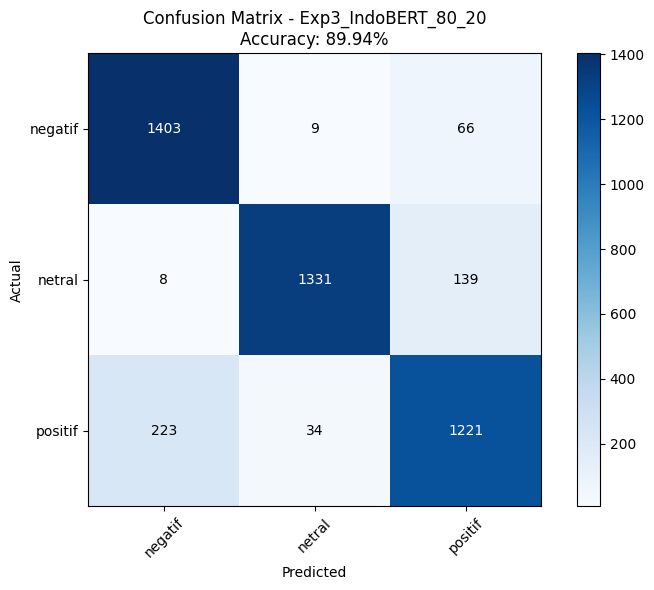

In [15]:
cm = confusion_matrix(y_test, pred_svm_test)
labels = ["negatif", "netral", "positif"]

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title(f"Confusion Matrix - {best_exp}\nAccuracy: {best_score*100:.2f}%")
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

---
# INFERENCE

In [16]:
contoh_teks = [
    "Aplikasinya sering error dan bikin emosi",
    "Biasa saja, lumayan buat kebutuhan saya",
    "Mantap! Fiturnya lengkap dan sangat membantu",
    "Netral sih, tapi kadang lemot",
    "Iklan kebanyakan, mengganggu banget",
    "Sangat bagus dan mudah digunakan",
    "Jelek banget ga bisa dipake",
    "Oke lah cukup membantu",
]

print("="*60)
print("HASIL PREDIKSI SENTIMENT")
print("="*60)

texts_clean = [clean_text_advanced(t) for t in contoh_teks]
X_vec = tfidf_1.transform(texts_clean)
predictions = svm.predict(X_vec)

for text, pred in zip(contoh_teks, predictions):
    label = id_to_label[pred]
    emoji = ":)" if label == "positif" else ":|" if label == "netral" else ":("
    print(f"\nTeks: {text}")
    print(f"Prediksi: {label.upper()} {emoji}")

HASIL PREDIKSI SENTIMENT

Teks: Aplikasinya sering error dan bikin emosi
Prediksi: NEGATIF :(

Teks: Biasa saja, lumayan buat kebutuhan saya
Prediksi: NETRAL :|

Teks: Mantap! Fiturnya lengkap dan sangat membantu
Prediksi: POSITIF :)

Teks: Netral sih, tapi kadang lemot
Prediksi: POSITIF :)

Teks: Iklan kebanyakan, mengganggu banget
Prediksi: NEGATIF :(

Teks: Sangat bagus dan mudah digunakan
Prediksi: POSITIF :)

Teks: Jelek banget ga bisa dipake
Prediksi: NEGATIF :(

Teks: Oke lah cukup membantu
Prediksi: POSITIF :)
